In [9]:
# 02_model_training.ipynb

### 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [10]:
### 2. Load Preprocessed Data
# Assumes 01_data_cleaning.ipynb saved cleaned data to /data/processed/cleaned_data.csv

df = pd.read_csv('data/processed/diabetes_cleaned.csv')
df.head()


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,5,6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,15,1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,25,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,35,1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,45,1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [11]:
# Separate features and target
X_raw = df.drop('readmitted', axis=1)
y = df['readmitted']

# Identify categorical columns
cat_cols = X_raw.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)

# One-hot encode categorical features
X = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)

# Save feature names for SHAP
feature_names = X.columns.tolist()


Categorical columns: ['race', 'gender', 'diag_1', 'diag_2', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [12]:
### 4. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (81412, 1530)
Test shape: (20354, 1530)


In [13]:
### 5. Baseline Model: Logistic Regression

logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.50      0.02      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.69      0.51      0.49     20354
weighted avg       0.85      0.89      0.84     20354

ROC AUC Score: 0.6457697032955796


In [14]:
### 6. Random Forest Model

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_SEED,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     18083
           1       0.17      0.59      0.26      2271

    accuracy                           0.63     20354
   macro avg       0.55      0.61      0.51     20354
weighted avg       0.84      0.63      0.70     20354

ROC AUC Score: 0.656853922247512


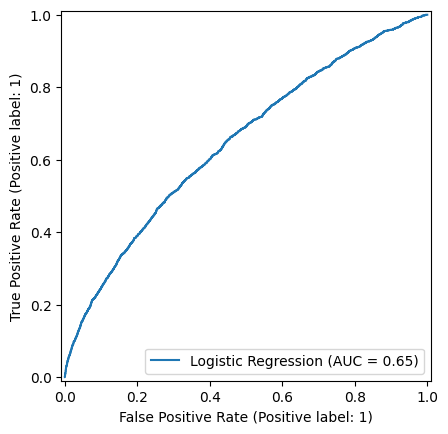

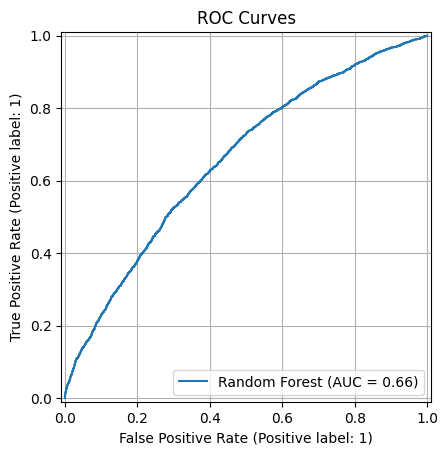

In [15]:
### 7. ROC Curves for Comparison

RocCurveDisplay.from_estimator(logreg, X_test, y_test, name='Logistic Regression')
RocCurveDisplay.from_estimator(rf, X_test, y_test, name='Random Forest')
plt.title("ROC Curves")
plt.grid()
plt.show()


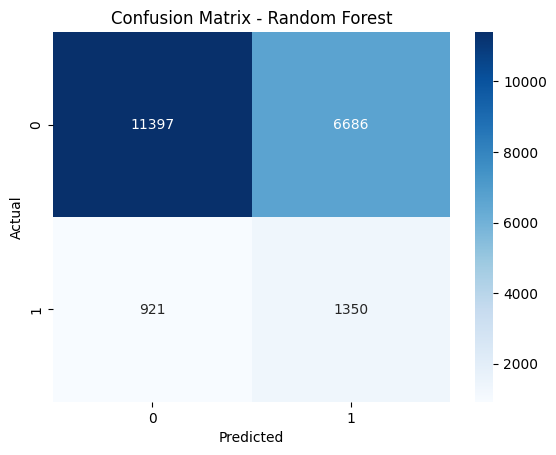

In [16]:
### 8. Confusion Matrix

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
### 9. Save Best Model (Random Forest)

joblib.dump({'model': rf, 'features': feature_names}, 'models/random_forest.pkl')
print("✅ Random Forest model saved to models/random_forest.pkl")


✅ Random Forest model saved to models/random_forest.pkl
